In [1]:
import os
os.chdir("..")
os.getcwd()

'/Users/laurasisson/odor-pair'

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import tqdm
import collections
import re
import json
import utils

In [3]:
random_seed = 3
random.seed(random_seed)

In [4]:
with open("dataset/full.json") as f:
    full_data = json.load(f)
full_data[0]

{'mol1': 'CCCCC/C=C/C(=O)OC',
 'mol1_notes': ['violet',
  'sweet',
  'oily',
  'melon',
  'pear',
  'hairy',
  'costus',
  'fruity',
  'violet leaf',
  'waxy',
  'fresh',
  'green'],
 'mol2': 'CCCCCOC(=O)CCC',
 'mol2_notes': ['cherry',
  'sweet',
  'pineapple',
  'fruity',
  'banana',
  'tropical'],
 'blend_notes': ['animal', 'fruity', 'waxy']}

In [5]:
import collections
blend_notes = collections.Counter()
mol_to_notes = dict()
for d in full_data:
    blend_notes.update(d["blend_notes"])
    mol_to_notes[d["mol1"]] = d["mol1_notes"]
    mol_to_notes[d["mol2"]] = d["mol2_notes"]
blend_notes.most_common(10)

[('fruity', 50409),
 ('floral', 47627),
 ('green', 29375),
 ('waxy', 11092),
 ('herbal', 9157),
 ('woody', 8707),
 ('balsamic', 7047),
 ('citrus', 5544),
 ('spicy', 5291),
 ('fatty', 4679)]

In [6]:
import collections
mol_counts = collections.Counter()
for d in full_data:
    mol_counts[d["mol1"]] += 1
    mol_counts[d["mol2"]] += 1
mol_counts.most_common(10)

[('CC(CC1=CC2=C(C=C1)OCO2)C=O', 807),
 ('OC(C1OC(\\C=C)(CC1)C)(C)C', 806),
 ('CC(CCC=C(C)C)CCOC(=O)C', 784),
 ('CC(=CCCC(C)(C=C)O)C', 765),
 ('CCCCCOC(=O)C1=CC=CC=C1', 741),
 ('CCC(C)C(=O)OCCC1=CC=CC=C1', 734),
 ('CCCCCCCCCO', 727),
 ('CCCCCOC(=O)C1=CC=CC=C1O', 721),
 ('CC(=O)OCCC1=CC=CC=C1', 695),
 ('CCOC(=O)C=CC1=CC=CC=C1', 675)]

In [7]:
import graph.utils

edge_to_notes = {graph.utils.sort(d["mol1"],d["mol2"]):d["blend_notes"] for d in full_data}

In [8]:
sample_size = 15
backbone = {mol for mol, _ in mol_counts.most_common(sample_size)}
backbone

{'CC(=CCC/C(=C/CO)/C)C',
 'CC(=CCCC(=CCCC(C)(C=C)O)C)C',
 'CC(=CCCC(C)(C=C)O)C',
 'CC(=O)OC1CCC(CC1)C(C)(C)C',
 'CC(=O)OCCC1=CC=CC=C1',
 'CC(CC1=CC2=C(C=C1)OCO2)C=O',
 'CC(CCC=C(C)C)CCOC(=O)C',
 'CCC(=O)OCC1=CC=CC=C1',
 'CCC(C)C(=O)OCCC1=CC=CC=C1',
 'CCCCCCCCCO',
 'CCCCCOC(=O)C1=CC=CC=C1',
 'CCCCCOC(=O)C1=CC=CC=C1O',
 'CCOC(=O)C=CC1=CC=CC=C1',
 'O=C(OC)CC1C(C(=O)CC1)CCCCC',
 'OC(C1OC(\\C=C)(CC1)C)(C)C'}

In [9]:
from tqdm.notebook import tqdm
from pubchempy import get_compounds

smiles_to_cid = {}
for smiles in tqdm(backbone):
    try:
        compounds = get_compounds(smiles, 'smiles')
        if compounds:
            smiles_to_cid[smiles] = compounds[0].cid
        else:
            smiles_to_cid[smiles] = None  # No CID found
    except Exception as e:
        smiles_to_cid[smiles] = None  # Handle errors gracefully
        print(f"Error processing {smiles}: {e}")
smiles_to_cid

  0%|          | 0/15 [00:00<?, ?it/s]

{'CCC(C)C(=O)OCCC1=CC=CC=C1': 520148,
 'CC(=CCC/C(=C/CO)/C)C': 637566,
 'CC(CCC=C(C)C)CCOC(=O)C': 9017,
 'CC(=O)OC1CCC(CC1)C(C)(C)C': 36081,
 'CC(=O)OCCC1=CC=CC=C1': 7654,
 'O=C(OC)CC1C(C(=O)CC1)CCCCC': 102861,
 'OC(C1OC(\\C=C)(CC1)C)(C)C': 22310,
 'CC(CC1=CC2=C(C=C1)OCO2)C=O': 64805,
 'CCC(=O)OCC1=CC=CC=C1': 31219,
 'CCOC(=O)C=CC1=CC=CC=C1': 7649,
 'CC(=CCCC(=CCCC(C)(C=C)O)C)C': 8888,
 'CCCCCOC(=O)C1=CC=CC=C1': 16296,
 'CCCCCCCCCO': 8914,
 'CCCCCOC(=O)C1=CC=CC=C1O': 16299,
 'CC(=CCCC(C)(C=C)O)C': 6549}

In [10]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(list(backbone), test_size=0.5, random_state=random_seed)

train, test = list(train), list(test)
node_order = train + test

In [11]:
G = nx.Graph()
for d in full_data:
    m1,m2 = d["mol1"],d["mol2"]
    if not m1 in backbone or not m2 in backbone:
        continue
    m1, m2 = graph.utils.sort(m1,m2)
    G.add_edge(m1,m2)
len(G.edges())/len(G.nodes())

6.6

In [51]:
import matplotlib.patheffects as pe

# Define path effects for the white border
text_path_effects = [
    pe.Stroke(linewidth=3, foreground='whitesmoke'),  # White border
    pe.Normal()  # Normal text inside
]

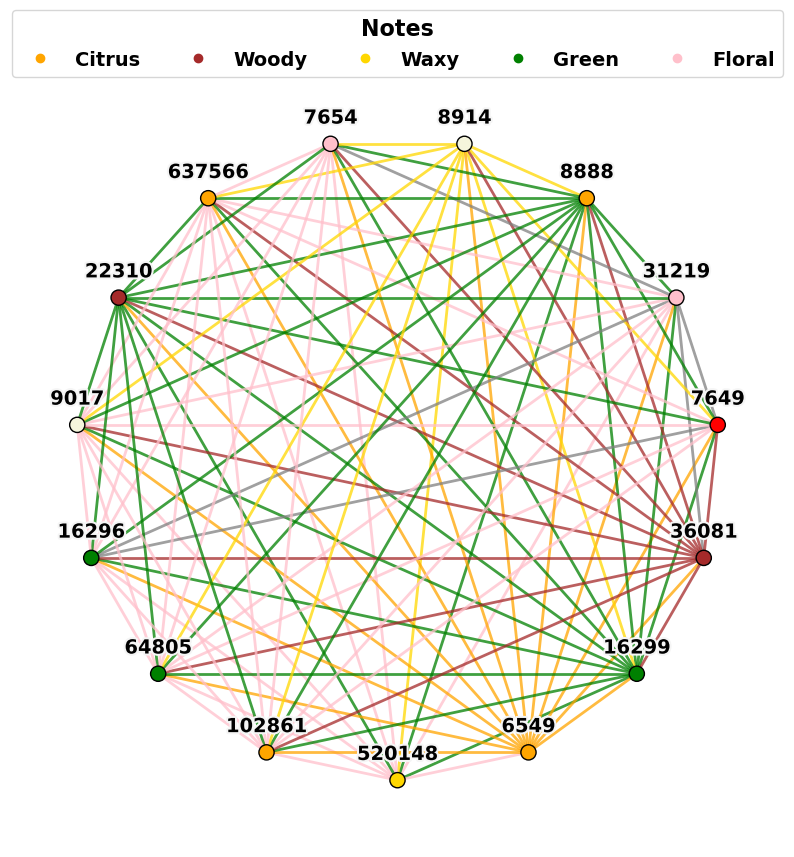

In [83]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import networkx as nx
import collections
import random
import re
plt.rcParams.update({'font.size': 16})

# Suppress specific DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*alltrue.*")

node_size = 120
small_edge = 2
big_edge = 3

yoffset = 8e-2

used = set()

# Define your note to color mapping
note_color_mapping = {
    'fatty': 'beige',
    'spicy': 'red',
    'citrus': 'orange',
    # 'balsamic': 'purple',
    'woody': 'brown',
    # 'herbal': 'lightgreen',
    'waxy': 'gold',
    'green': 'green',
    'floral': 'pink',
    # 'fruity': 'red'
}

def get_color_from_notes(notes):
    for note, color in note_color_mapping.items():
        if note in notes:
            return color
    return 'gray'  # default color if no matching note

def get_edge_style(edge):
    global used
    
    m1, m2 = edge
    notes = edge_to_notes[graph.utils.sort(m1,m2)]
    color = get_color_from_notes(notes)
    used.add(color)
    return 'solid', color, small_edge

def get_node_color(node):
    notes = mol_to_notes[node]
    return get_color_from_notes(notes)

fig, ax = utils.standard_fig_ax()

# Create a new graph and add nodes in the specified order
ordered_subgraph = nx.Graph()
ordered_subgraph.add_nodes_from(node_order)

# Add all edges from the original graph to the new ordered graph
ordered_subgraph.add_edges_from(G.edges())
# Use circular layout with the ordered subgraph
pos = nx.circular_layout(ordered_subgraph)

# Rotate positions by 90 degrees
theta = -np.pi / 2  # 90 degrees in radians
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

pos = {node: np.dot(rotation_matrix, pos[node]) for node in pos}

# nx.draw_networkx_nodes(ordered_subgraph, pos, node_size=node_size, nodelist=ordered_subgraph.nodes(),
#                        node_color='black')
node_colors = [get_node_color(n) for n in ordered_subgraph.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_size, nodelist=ordered_subgraph.nodes(),
                       node_color=node_colors, edgecolors='black', linewidths=1)


# Get the edge styles, colors, and weights for the subgraph
edge_styles, edge_colors, edge_weights = list(zip(*[get_edge_style(edge) for edge in ordered_subgraph.edges()]))
nx.draw_networkx_edges(ordered_subgraph, pos, style=edge_styles, edge_color=edge_colors, width=edge_weights, alpha=.75)

# Clean the names for labels
labels = {s:smiles_to_cid[s] for s in pos}
labels_pos = {k: [x, y + yoffset] for k, (x, y) in pos.items()}

# Draw labels manually with path effects
for node, (x, y) in labels_pos.items():
    label = labels[node]
    ax.text(
        x, y, label,
        fontsize=14,
        color='black',  # Text color
        ha='center', va='center',  # Center alignment
        path_effects=text_path_effects  # Add white border
    )


# Add legend with colors used
for note, color in note_color_mapping.items():
    if color not in used:
        continue
    ax.plot([], [], label=note.capitalize(), color=color, linestyle='', marker='o')

# Add horizontal legend at the title position
plt.legend(
    title="Notes", 
    loc="upper center", 
    bbox_to_anchor=(0.5, 1.1),  # Position legend at the top center
    ncol=5,  # Adjust columns for compactness
    title_fontsize=16,
    fontsize=14
)

# Ensure the axes are square
ax.set_aspect('equal', adjustable='datalim')
plt.box(False)

utils.save_figures(f"backbone{sample_size}", fig)
plt.show()

7 train molecules and 8 test molecules.
Average degree = 6 and carving width = 99


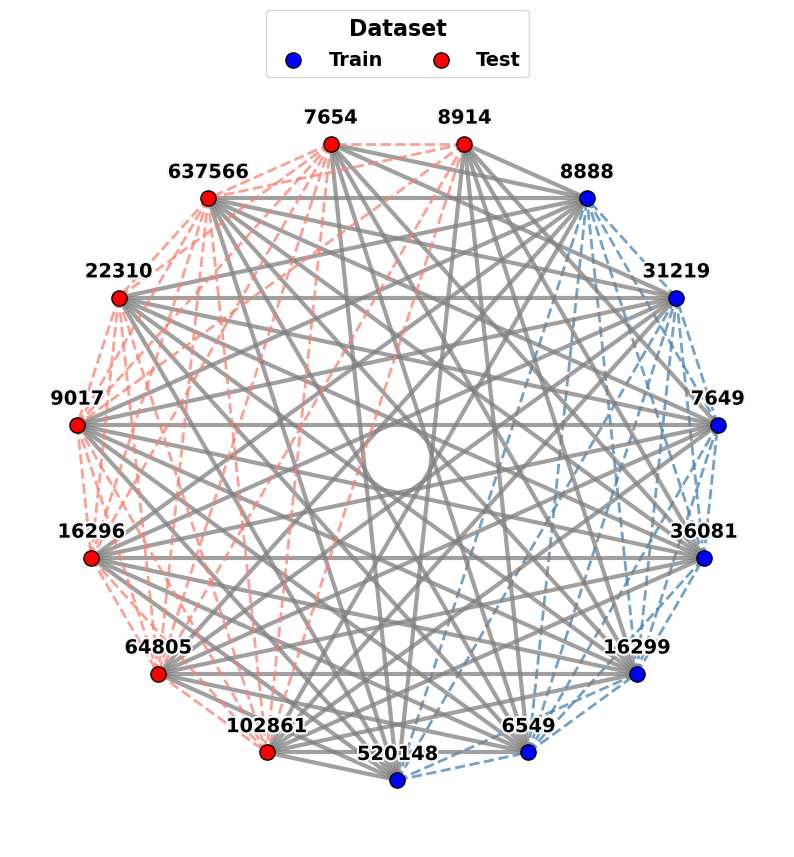

In [73]:
import warnings
import numpy as np

fig, ax = utils.standard_fig_ax()

train_color = "blue"
test_color = "red"

def get_edge_style(edge):
    m1, m2 = edge
    if m1 in train and m2 in train:
        return 'dashed', 'steelblue', small_edge
    if m1 in test and m2 in test:
        return 'dashed', 'salmon', small_edge
    return 'solid', 'grey', big_edge

# Create a new graph and add nodes in the specified order
ordered_subgraph = nx.Graph()
ordered_subgraph.add_nodes_from(node_order)

# Add all edges from the original graph to the new ordered graph
ordered_subgraph.add_edges_from(G.edges())
# Use circular layout with the ordered subgraph
pos = nx.circular_layout(ordered_subgraph)

# Rotate positions by 90 degrees
theta = -np.pi / 2  # 90 degrees in radians
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

pos = {node: np.dot(rotation_matrix, pos[node]) for node in pos}

# Draw train nodes
nx.draw_networkx_nodes(
    G, pos, node_size=node_size, nodelist=train,
    node_color=train_color, label='Train', edgecolors='black', linewidths=1
)

# Draw test nodes
nx.draw_networkx_nodes(
    G, pos, node_size=node_size, nodelist=test,
    node_color=test_color, label='Test', edgecolors='black', linewidths=1
)

# Draw edges
edge_styles, edge_colors, edge_weights = list(zip(*[
    get_edge_style(edge) for edge in ordered_subgraph.edges()
]))
nx.draw_networkx_edges(
    ordered_subgraph, pos, style=edge_styles, edge_color=edge_colors, 
    width=edge_weights, alpha=.75
)

# Draw labels
labels = {k: v for k, v in smiles_to_cid.items() if k in pos}
labels_pos = {k: [x, y + yoffset] for k, (x, y) in pos.items()}
# Draw labels manually with path effects
for node, (x, y) in labels_pos.items():
    label = labels[node]
    ax.text(
        x, y, label,
        fontsize=14,
        color='black',  # Text color
        ha='center', va='center',  # Center alignment
        path_effects=text_path_effects  # Add white border
    )


# Add horizontal legend at the title position
plt.legend(
    title="Dataset", 
    loc="upper center", 
    bbox_to_anchor=(0.5, 1.1),  # Position legend at the top center
    ncol=2,  # Adjust as needed for compactness
    title_fontsize=16,
    fontsize=14,
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Ensure the axes are square
ax.set_aspect('equal', adjustable='datalim')

# Print summary stats
print(f"{len(train)} train molecules and {len(test)} test molecules.")
print(f"Average degree = {int(G.number_of_edges() / G.number_of_nodes())} and carving width = {carving_width}")

# Ensure the axes are square
ax.set_aspect('equal', adjustable='datalim')
# Final adjustments
plt.box(False)

utils.save_figures(f"carving{sample_size}", fig)
plt.show()